In [1]:
pip install torch torchvision pillow numpy matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 8.0 MB/s eta 0:00:000:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

Filtered classes: ['Mild Dementia', 'Moderate Dementia', 'Very mild Dementia']
Label mapping: {0: 0, 1: 1, 3: 2}
Epoch [1/6]
Train Loss: 0.4734, Train Accuracy: 80.18%
Epoch [2/6]
Train Loss: 0.1550, Train Accuracy: 94.93%
Val Loss: 0.1104, Val Accuracy: 96.90%
Epoch [3/6]
Train Loss: 0.0558, Train Accuracy: 98.80%
Epoch [4/6]
Train Loss: 0.0318, Train Accuracy: 99.41%
Val Loss: 0.0162, Val Accuracy: 99.82%
Epoch [5/6]
Train Loss: 0.0148, Train Accuracy: 99.84%
Epoch [6/6]
Train Loss: 0.0078, Train Accuracy: 99.95%
Val Loss: 0.0067, Val Accuracy: 99.95%


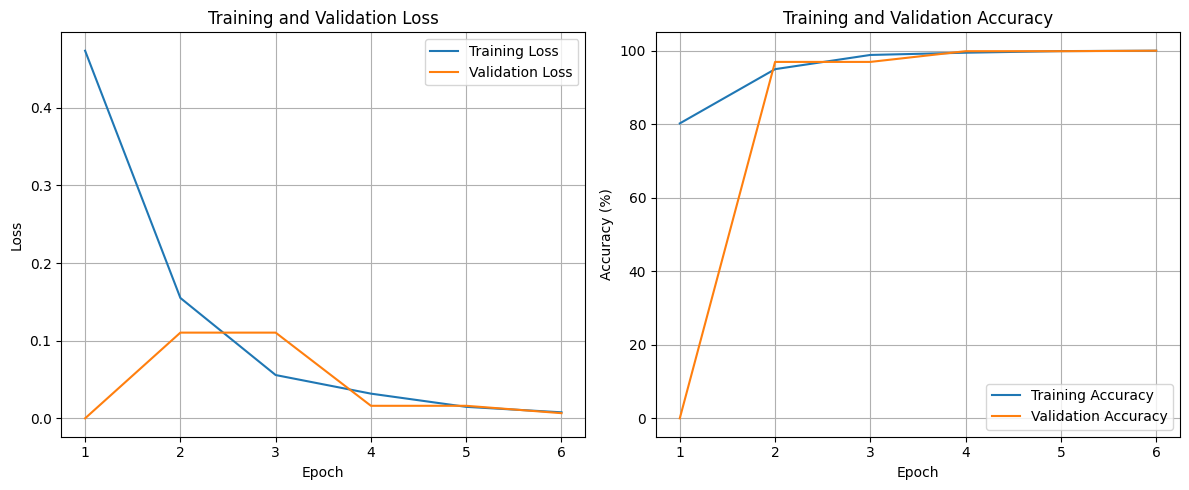

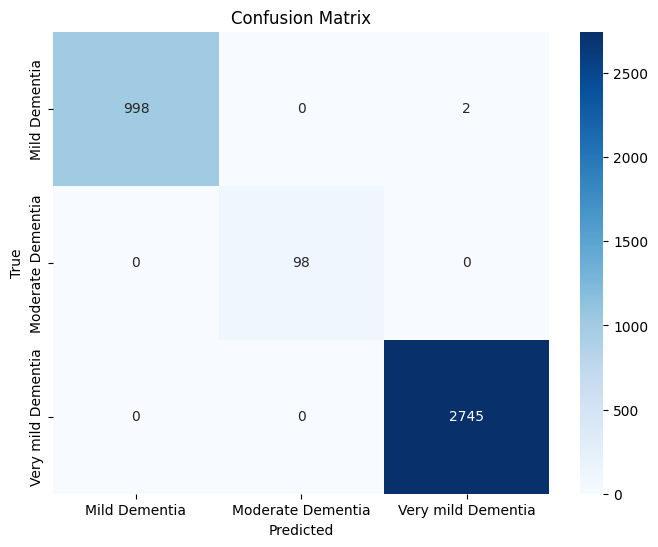


Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      1.00      1.00      1000
 Moderate Dementia       1.00      1.00      1.00        98
Very mild Dementia       1.00      1.00      1.00      2745

          accuracy                           1.00      3843
         macro avg       1.00      1.00      1.00      3843
      weighted avg       1.00      1.00      1.00      3843



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import shutil
import os

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Copy dataset to working directory for faster I/O
data_dir = '/kaggle/input/imagesoasis/Data'
working_dir = '/kaggle/working/oasis_data'
if not os.path.exists(working_dir):
    shutil.copytree(data_dir, working_dir)
data_dir = working_dir

# Transforms with grayscale conversion
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert RGB to grayscale
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for 1 channel
])

# Load dataset
original_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
class_names = original_dataset.classes
class_to_idx = original_dataset.class_to_idx

# Exclude Non-Demented
exclude_class = 'Non Demented'
if exclude_class in class_to_idx:
    exclude_idx = class_to_idx[exclude_class]
    # Filter indices to exclude Non-Demented
    filtered_indices = [i for i, target in enumerate(original_dataset.targets) if target != exclude_idx]
    # Create label mapping to remap original indices to [0, 1, 2]
    label_mapping = {i: idx for idx, i in enumerate(sorted(set(original_dataset.targets) - {exclude_idx}))}
    # Remap labels
    filtered_labels = [label_mapping[original_dataset.targets[i]] for i in filtered_indices]
    dataset = torch.utils.data.Subset(original_dataset, filtered_indices)
    # Update class names
    class_names = [name for name in class_names if name != exclude_class]
    num_classes = len(class_names)
else:
    raise ValueError(f"Class {exclude_class} not found in dataset")

print("Filtered classes:", class_names)
print("Label mapping:", label_mapping)
assert num_classes == 3, f"Expected 3 classes, got {num_classes}"

# Split filtered dataset
train_idx, val_idx = train_test_split(
    list(range(len(filtered_indices))),  # Index into filtered_indices
    test_size=0.2, stratify=filtered_labels, random_state=42
)

# Map back to original dataset indices
train_indices = [filtered_indices[i] for i in train_idx]
val_indices = [filtered_indices[i] for i in val_idx]

# Create train and validation datasets
train_dataset = torch.utils.data.Subset(original_dataset, train_indices)
val_dataset = torch.utils.data.Subset(original_dataset, val_indices)

# Data loaders with optimization
batch_size = 64  # Increased for speed
num_workers = 4  # Parallel data loading
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True
)

# CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):  # 3 classes
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, num_classes)
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

# Initialize model, loss, optimizer
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()  # No class weights
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 6
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_correct = 0
    train_total = 0
    train_loss = 0.0
    
    for images, labels in train_loader:
        # Remap labels to [0, 1, 2]
        labels = torch.tensor([label_mapping[l.item()] for l in labels]).to(device)
        images = images.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        train_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validate every 2 epochs
    if (epoch + 1) % 2 == 0:
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                # Remap labels to [0, 1, 2]
                labels = torch.tensor([label_mapping[l.item()] for l in labels]).to(device)
                images = images.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += loss.item()
        
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    else:
        val_losses.append(val_losses[-1] if val_losses else 0)
        val_accuracies.append(val_accuracies[-1] if val_accuracies else 0)
    
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    if (epoch + 1) % 2 == 0:
        print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

# Visualize training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history_3classes.png', dpi=300, bbox_inches='tight')
plt.show()

# Confusion matrix and class-wise metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        labels = torch.tensor([label_mapping[l.item()] for l in labels]).to(device)
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_3classes.png', dpi=300, bbox_inches='tight')
plt.show()

# Class-wise metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Save model
torch.save(model.state_dict(), 'cnn_alzheimer_3classes.pth')